# Fake News Detection Using BERT and Deep Learning Approaches
**Author:** Deniz Can Calkin  
**Date:** June 29, 2025  
**Course:** SS25 - Machine Learning A

In [ ]:
# Cell 1: Import Required Libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cpu")
print(f"Using device: {device}")

In [2]:
# Cell 2: Load and Explore Dataset
# Load the datasets
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

# Add labels
true_df['label'] = 1  # 1 for real news
fake_df['label'] = 0  # 0 for fake news

# Combine datasets
df = pd.concat([true_df, fake_df], ignore_index=True)

# Display basic information
print(f"Total samples: {len(df)}")
print(f"Real news: {len(true_df)}")
print(f"Fake news: {len(fake_df)}")
print("\nDataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())

Total samples: 44898
Real news: 21417
Fake news: 23481

Dataset shape: (44898, 5)

Columns: ['title', 'text', 'subject', 'date', 'label']


In [3]:
# Cell 3: Data Preprocessing
# Combine title and text as mentioned in proposal
df['combined_text'] = df['title'] + " " + df['text']

# Remove any null values
df = df.dropna(subset=['combined_text'])

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display sample data
print("Sample Real News:")
print(df[df['label']==1]['combined_text'].iloc[0][:500])
print("\nSample Fake News:")
print(df[df['label']==0]['combined_text'].iloc[0][:500])

Sample Real News:
California AG pledges to defend birth control insurance coverage SAN FRANCISCO (Reuters) - California Attorney General Xavier Becerra said on Friday he was “prepared to take whatever action it takes” to defend the Obamacare mandate that health insurers provide birth control, now that the Trump administration has moved to circumvent it. The administration’s new contraception exemptions “are another example of the Trump administration trampling on people’s rights, but in this case only women,” Bec

Sample Fake News:
 BREAKING: GOP Chairman Grassley Has Had Enough, DEMANDS Trump Jr. Testimony Donald Trump s White House is in chaos, and they are trying to cover it up. Their Russia problems are mounting by the hour, and they refuse to acknowledge that there are problems surrounding all of this. To them, it s  fake news,  or a  hoax.  However, the facts bear things out differently, and it seems that there are now cracks in the Congressional public leadership.Chuck Grassley 

In [ ]:
# Cell 4: Create Train/Validation/Test Split
# Split data
X = df['combined_text'].values[:10000]
y = df['label'].values[:10000]

# 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 7004
Validation samples: 1496
Test samples: 1500


In [5]:
# Cell 5: Traditional ML Models (Baseline)
# Vectorize text for traditional models
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_val_tfidf)
nb_acc = accuracy_score(y_val, nb_pred)
nb_f1 = f1_score(y_val, nb_pred)

print(f"Naive Bayes - Accuracy: {nb_acc:.4f}, F1-Score: {nb_f1:.4f}")

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_val_tfidf)
lr_acc = accuracy_score(y_val, lr_pred)
lr_f1 = f1_score(y_val, lr_pred)

print(f"Logistic Regression - Accuracy: {lr_acc:.4f}, F1-Score: {lr_f1:.4f}")

Naive Bayes - Accuracy: 0.9298, F1-Score: 0.9272
Logistic Regression - Accuracy: 0.9759, F1-Score: 0.9753


In [ ]:
# Cell 6: BERT Dataset Class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Cell 7: Initialize BERT Model and Tokenizer
# Load pre-trained BERT
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device("cpu")
model = model.to(device)

# Create data loaders
batch_size = 8  
train_dataset = NewsDataset(X_train, y_train, tokenizer, max_length=256) 
val_dataset = NewsDataset(X_val, y_val, tokenizer, max_length=256)
test_dataset = NewsDataset(X_test, y_test, tokenizer, max_length=256)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Cell 8: Training Configuration
# Optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 2  # Limited due to time constraint
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [9]:
# Cell 9: Training Function
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy

In [10]:
# Cell 10: Evaluation Function
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy, all_predictions, all_labels

In [11]:
# Cell 11: Train BERT Model
print("Starting BERT training...")
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validate
    val_loss, val_acc, _, _ = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Starting BERT training...

Epoch 1/2


Evaluating: 100%|█████████████████████████████| 187/187 [01:28<00:00,  2.12it/s]


Train Loss: 0.0291, Train Acc: 0.9914
Val Loss: 0.0004, Val Acc: 1.0000

Epoch 2/2


Evaluating: 100%|█████████████████████████████| 187/187 [01:29<00:00,  2.08it/s]

Train Loss: 0.0046, Train Acc: 0.9989
Val Loss: 0.0037, Val Acc: 0.9993


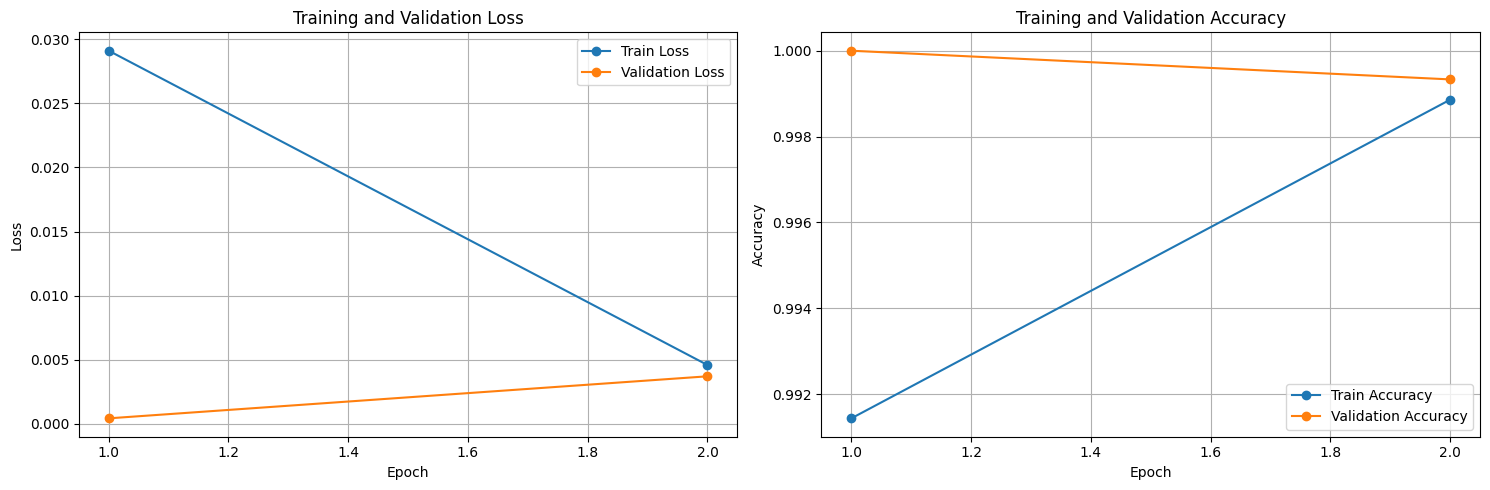

In [12]:
# Cell 12: Plot Training Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
ax1.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', marker='o')
ax2.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Cell 13: Final Evaluation on Test Set
print("\nEvaluating on test set...")
test_loss, test_acc, test_predictions, test_labels = evaluate(model, test_loader, device)
test_f1 = f1_score(test_labels, test_predictions)

print(f"\nTest Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1-Score: {test_f1:.4f}")


Evaluating on test set...


Evaluating: 100%|█████████████████████████████| 188/188 [01:27<00:00,  2.14it/s]


Test Results:
Accuracy: 0.9967
F1-Score: 0.9965


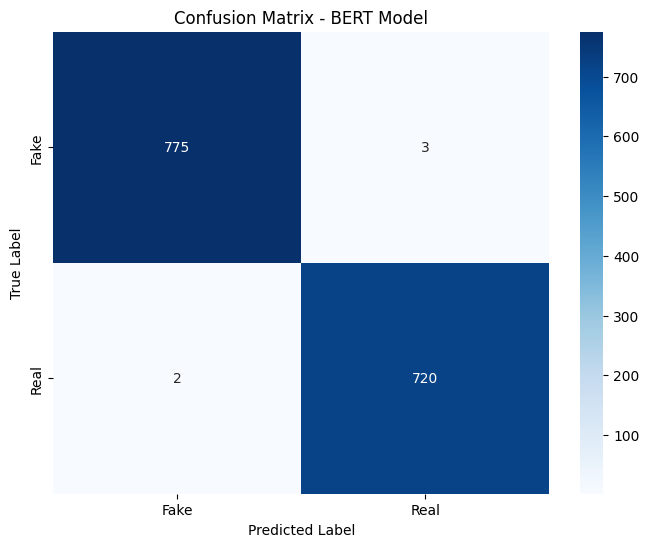

In [14]:
# Cell 14: Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix - BERT Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
# Cell 15: Model Comparison Table
results_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 'BERT'],
    'Accuracy': [nb_acc, lr_acc, test_acc],
    'F1 Score': [nb_f1, lr_f1, test_f1]
})

print("\n=== Model Performance Comparison ===")
print(results_df.to_string(index=False))


=== Model Performance Comparison ===
              Model  Accuracy  F1 Score
        Naive Bayes  0.929813  0.927235
Logistic Regression  0.975936  0.975309
               BERT  0.996667  0.996540


In [16]:
# Cell 16: Sample Predictions (3 Correct and 3 Incorrect)
def get_sample_predictions(model, tokenizer, texts, labels, device):
    model.eval()
    predictions = []
    
    for text in texts:
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            predictions.append(predicted.item())
    
    return predictions

# Find correct and incorrect predictions
test_predictions_detailed = get_sample_predictions(model, tokenizer, X_test, y_test, device)

correct_indices = []
incorrect_indices = []

for i in range(len(test_predictions_detailed)):
    if test_predictions_detailed[i] == y_test[i]:
        correct_indices.append(i)
    else:
        incorrect_indices.append(i)

# Display 3 correct predictions
print("\n=== 3 CORRECT PREDICTIONS ===")
for i in range(min(3, len(correct_indices))):
    idx = correct_indices[i]
    print(f"\nCorrect Prediction {i+1}:")
    print(f"Text: {X_test[idx][:200]}...")
    print(f"True Label: {'Real' if y_test[idx] == 1 else 'Fake'}")
    print(f"Predicted: {'Real' if test_predictions_detailed[idx] == 1 else 'Fake'}")

# Display 3 incorrect predictions
print("\n=== 3 INCORRECT PREDICTIONS ===")
for i in range(min(3, len(incorrect_indices))):
    idx = incorrect_indices[i]
    print(f"\nIncorrect Prediction {i+1}:")
    print(f"Text: {X_test[idx][:200]}...")
    print(f"True Label: {'Real' if y_test[idx] == 1 else 'Fake'}")
    print(f"Predicted: {'Real' if test_predictions_detailed[idx] == 1 else 'Fake'}")


=== 3 CORRECT PREDICTIONS ===

Correct Prediction 1:
Text: Japanese PM Abe says election won't distract him from tackling North Korea TOKYO (Reuters) - Japanese Prime Minister Shinzo Abe on Monday said his decision to call a snap election would not distract h...
True Label: Real
Predicted: Real

Correct Prediction 2:
Text: WATCH: 75-YR OLD TRUMP SUPPORTER Says She’d Rather Go To Jail Than Remove Trump Signs From Front Yard In a city that has more registered Democrats than Republicans, one has to wonder if the sizes of t...
True Label: Fake
Predicted: Fake

Correct Prediction 3:
Text:  Breaking: Dems Keep Progressive Bent In All-Important Leadership Election (DETAILS) Nancy Pelosi has been the leader of the House Democrats for a very long time, and she is well-respected. However, i...
True Label: Fake
Predicted: Fake

=== 3 INCORRECT PREDICTIONS ===

Incorrect Prediction 1:
Text: White House unveils list of ex-lobbyists granted ethics waivers The White House on Wednesday disclosed a gr

In [17]:
# Cell 17: Save Model
# Save the trained model
model.save_pretrained('./bert_fake_news_model')
tokenizer.save_pretrained('./bert_fake_news_model')
print("\nModel saved successfully!")


Model saved successfully!


In [18]:
# Cell 18: Test with New Examples (Not from training/validation/test sets)
# Create some new examples for demonstration
new_examples = [
    "Scientists discover new species of butterfly in Amazon rainforest that can change colors",
    "Aliens have landed in New York City and are demanding to speak with world leaders",
    "New study shows that regular exercise can improve mental health and reduce stress"
]

print("\n=== Predictions on New Examples ===")
new_predictions = get_sample_predictions(model, tokenizer, new_examples, [0, 0, 0], device)

for i, (text, pred) in enumerate(zip(new_examples, new_predictions)):
    print(f"\nExample {i+1}:")
    print(f"Text: {text}")
    print(f"Prediction: {'Real News' if pred == 1 else 'Fake News'}")


=== Predictions on New Examples ===

Example 1:
Text: Scientists discover new species of butterfly in Amazon rainforest that can change colors
Prediction: Fake News

Example 2:
Text: Aliens have landed in New York City and are demanding to speak with world leaders
Prediction: Fake News

Example 3:
Text: New study shows that regular exercise can improve mental health and reduce stress
Prediction: Fake News
